We will implement a Gibbs sampling algortihm to sample the factors from the conditional posterior distrubtions in the MVGMF algorithm to factorise our matrix. We will call this algortihm Bayesian Gaussian Matrix Factorisation (BGMF) for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calculate_nmse(Y, Y_pred):
    numerator = np.linalg.norm(Y - Y_pred, 'fro') ** 2
    denominator = np.linalg.norm(Y, 'fro') ** 2
    nmse = numerator / denominator
    return nmse

In [3]:
def matrix_normal_sample(M, U, V):
    return np.random.multivariate_normal(M.ravel(), np.kron(V, U)).reshape(M.shape)

In [7]:
def BGMF(Y, k, r, T, burnin = 100, return_running_average = False):
    """
    Perform Bayesian Gaussian Matrix Factorization (BGMF) using Gibbs sampling.

    Parameters:
    - Y (numpy.ndarray): The input matrix of shape (m, n) to be factorized.
    - k (float): A constant for the variate matrix initialization.
    - r (int): The dimensionality of the factorization.
    - T (int): The number of Gibbs sampling iterations.

    Returns:
    - C (numpy.ndarray): The factor matrix C of shape (m, r).
    - X (numpy.ndarray): The factor matrix X of shape (r, n).
    """
    m, n = Y.shape
    sigma_2 = 1

    #Initialise the matrices
    V_0 = k * np.eye(r)
    W_0 = k * np.eye(r)
    C_prev = np.random.normal(0, 1, size=(m, r))
    X_prev = np.random.normal(0, 1, size=(r, n))
    C = np.zeros((m, r))
    X_prev
    
    #Stores running average of C and X after burnin
    C_running_average = []
    X_running_average = []
    C_average = np.zeros((m, r))
    X_average = np.zeros((r, n))

    for t in range(T):
        
        
        V = V_0 - V_0@X_prev@np.linalg.inv(sigma_2*np.eye(n) + X_prev.T@V_0@X_prev).T @ X_prev.T @ V_0.T
        
        C_mean = C_prev + (Y - C_prev @ X_prev) @ \
                    np.linalg.inv(sigma_2*np.eye(n) + X_prev.T@V_0@X_prev).T @ X_prev.T @ V_0.T
        
        C = matrix_normal_sample(C_mean, np.eye(m), V)
        
        
        
        W = W_0 - W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ C @ W_0
        
        X_mean = X_prev + W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ (Y - C @ X_prev)
        
        X = matrix_normal_sample(X_mean, W, np.eye(n))
        
        C_prev = C
        X_prev = X
        

        if t > burnin:

            if t == burnin + 1:
                C_average = C
                X_average = X
                C_running_average.append(C_average)
                X_running_average.append(X_average)

            N = t - burnin
            C_average = (C / N) + (C_average * (N - 1) / N)
            X_average = (X / N) + (X_average * (N - 1) / N)
            C_running_average.append(C_average)
            X_running_average.append(X_average)





    if return_running_average:
        return C_average, X_average, C_running_average, X_running_average
            
    return C_average, X_average

In [39]:
m = 5
r = 3
n = 25
burnin = 100
T = 500

C = np.random.normal(0, 1, size=(m, r))
X = np.random.normal(0, 1, size=(r, n))

Y = C @ X

C_pred, X_pred, C_average, X_average = BGMF(Y, 1, r, T, burnin = burnin, return_running_average = True)

Y_pred = C_pred @ X_pred

#RUNNING PREDICITION CALCULATION
Y_pred_running = [C @ X for C, X in zip(C_average, X_average)]
nmse_running = [calculate_nmse(Y, Y_pred) for Y_pred in Y_pred_running]

calculate_nmse(Y, Y_pred)

0.027964962568227936

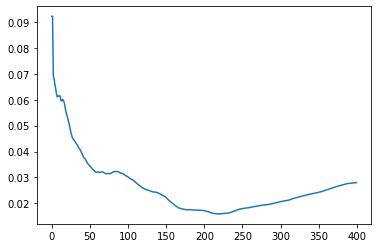

In [40]:
plt.plot(range(T-burnin), nmse_running)